In [1]:

import numpy as np
import tensorflow as tf

import wf_psf as wf

import wf_psf.SimPSFToolkit as SimPSFToolkit
import wf_psf.utils as wf_utils
import wf_psf.tf_psf_field as tf_psf_field


%pylab inline 


Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import ImageGrid

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')


plot_style = {
    'mpl_toolkits.legacy_colorbar': False,
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)

plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels


# Load model

In [3]:

# Model arguments
# (replaces the cli parameters)

args = {
    'dataset_folder': './../../../data/coherent_euclid_dataset/',
    'train_dataset_file': 'train_Euclid_res_2000_TrainStars_id_001.npy',
    'test_dataset_file': 'test_Euclid_res_id_001.npy',
    'weights_paths': './../data/models/wavediff-original/chkp_callback_poly_sample_w_bis1_2k_cycle2',
    'n_zernikes': 15,
    'pupil_diameter': 256,
    'output_dim': 32,
    'oversampling_rate': 3.,
    'output_q': 3.,
    'l2_param': 0.,
    'd_max': 2,
    'd_max_nonparam': 5,
    'x_lims': [0, 1e3],
    'y_lims': [0, 1e3],
    'gt_n_zernikes': 45,
    'batch_size': 16,
}


n_bins_lda = 20

saving_dir = './../figures/'



In [4]:

# Define model run id
# run_id_name = args['model'] + args['id_name']


## Check GPU and tensorflow version
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
print('tf_version: ' + str(tf.__version__))



## Load datasets
train_dataset = np.load(args['dataset_folder'] + args['train_dataset_file'], allow_pickle=True)[()]
# train_stars = train_dataset['stars']
noisy_train_stars = train_dataset['noisy_stars']
# train_pos = train_dataset['positions']
train_SEDs = train_dataset['SEDs']
# train_zernike_coef = train_dataset['zernike_coef']
train_C_poly = train_dataset['C_poly']
train_parameters = train_dataset['parameters']

test_dataset = np.load(args['dataset_folder'] + args['test_dataset_file'], allow_pickle=True)[()]
test_stars = test_dataset['stars']
test_pos = test_dataset['positions']
test_SEDs = test_dataset['SEDs']
# test_zernike_coef = test_dataset['zernike_coef']

# Convert to tensor
tf_noisy_train_stars = tf.convert_to_tensor(train_dataset['noisy_stars'], dtype=tf.float32)
tf_train_pos = tf.convert_to_tensor(train_dataset['positions'], dtype=tf.float32)
tf_test_pos = tf.convert_to_tensor(test_dataset['positions'], dtype=tf.float32)

print('Dataset parameters:')
print(train_parameters)


## Prepare models
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(n_zernikes=args['n_zernikes'], wfe_dim=args['pupil_diameter'])
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))

for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# Prepare np input
simPSF_np = SimPSFToolkit(
    zernikes,
    max_order=args['n_zernikes'],
    pupil_diameter=args['pupil_diameter'],
    output_dim=args['output_dim'],
    oversampling_rate=args['oversampling_rate'],
    output_Q=args['output_q']
)
simPSF_np.gen_random_Z_coeffs(max_order=args['n_zernikes'])
z_coeffs = simPSF_np.normalize_zernikes(simPSF_np.get_z_coeffs(), simPSF_np.max_wfe_rms)
simPSF_np.set_z_coeffs(z_coeffs)
simPSF_np.generate_mono_PSF(lambda_obs=0.7, regen_sample=False)

# Obscurations
obscurations = simPSF_np.generate_pupil_obscurations(N_pix=args['pupil_diameter'], N_filter=2)
tf_obscurations = tf.convert_to_tensor(obscurations, dtype=tf.complex64)

# Outputs (needed for the MCCD model)
outputs = tf_noisy_train_stars



Found GPU at: /device:GPU:0
tf_version: 2.4.1
Dataset parameters:
{'d_max': 2, 'max_order': 45, 'x_lims': [0, 1000.0], 'y_lims': [0, 1000.0], 'grid_points': [4, 4], 'n_bins': 20, 'max_wfe_rms': 0.1, 'oversampling_rate': 3.0, 'output_Q': 3.0, 'output_dim': 32, 'LP_filter_length': 2, 'pupil_diameter': 256, 'euclid_obsc': True, 'n_stars': 2000}


In [5]:

# # Initialize the model
tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube,
    obscurations=tf_obscurations,
    batch_size=args['batch_size'],
    output_Q=args['output_q'],
    d_max_nonparam=args['d_max_nonparam'],
    l2_param=args['l2_param'],
    output_dim=args['output_dim'],
    n_zernikes=args['n_zernikes'],
    d_max=args['d_max'],
    x_lims=args['x_lims'],
    y_lims=args['y_lims']
)

In [6]:

## Load the model's weights
tf_semiparam_field.load_weights(args['weights_paths'])

# Get the data-driven features
DD_features = tf_semiparam_field.tf_np_poly_opd.S_mat.numpy()


# Prepare the Ground Truth (GT) model

In [7]:

## Prepare ground truth model
# Generate Zernike maps
zernikes = wf_utils.zernike_generator(n_zernikes=args['gt_n_zernikes'], wfe_dim=args['pupil_diameter'])
# Now as cubes
np_zernike_cube = np.zeros((len(zernikes), zernikes[0].shape[0], zernikes[0].shape[1]))
for it in range(len(zernikes)):
    np_zernike_cube[it,:,:] = zernikes[it]

np_zernike_cube[np.isnan(np_zernike_cube)] = 0
tf_zernike_cube = tf.convert_to_tensor(np_zernike_cube, dtype=tf.float32)

# Initialize the model
GT_tf_semiparam_field = tf_psf_field.TF_SemiParam_field(
    zernike_maps=tf_zernike_cube,
    obscurations=tf_obscurations,
    batch_size=args['batch_size'],
    output_Q=args['output_q'],
    d_max_nonparam=args['d_max_nonparam'],
    output_dim=args['output_dim'],
    n_zernikes=args['gt_n_zernikes'],
    d_max=args['d_max'],
    x_lims=args['x_lims'],
    y_lims=args['y_lims']
)

# For the Ground truth model
GT_tf_semiparam_field.tf_poly_Z_field.assign_coeff_matrix(train_C_poly)
_ = GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat.assign(
    np.zeros_like(GT_tf_semiparam_field.tf_np_poly_opd.alpha_mat)
)





# Learned data-driven features

<ipython-input-8-ed80803ee61e>:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible


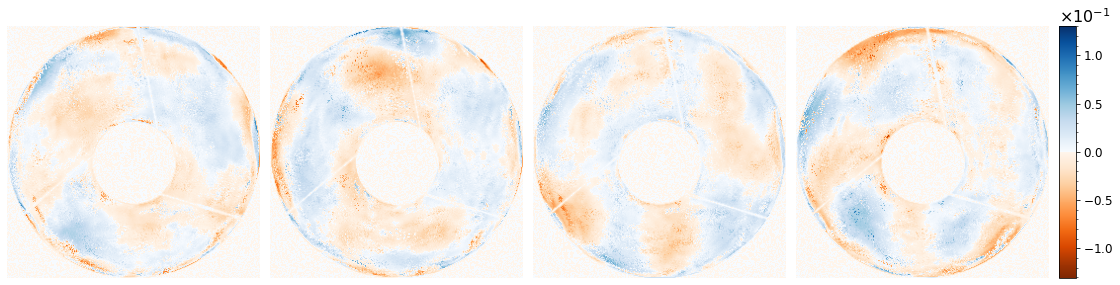

In [8]:

id_maps = [1, 2, 4, 5]

# Set up figure and image grid
fig = plt.figure(figsize=(16, 4))

grid = ImageGrid(
    fig,
    111,          # as in plt.subplot(111)
    nrows_ncols=(1,4),
    axes_pad=0.15,
    share_all=True,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.15,
)

vmax = np.max(abs(DD_features[id_maps,:,:]))

# Add data to image grid
it = 0
for ax in grid:
    im = ax.imshow(DD_features[id_maps[it],:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    ax.set_xticks([]);ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    it += 1

# Colorbar
cbar = ax.cax.colorbar(im)
ax.cax.toggle_label(True)

cbar.minorticks_on()
# cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
# cbar.ax.formatter._useMathText = True
cbar.ax.yaxis.offsetText.set(size=16)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible

plt.savefig(saving_dir + 'DD_features_example.pdf')

plt.show()





# PSF recovery

## Recovery @ Euclid resolution

In [9]:


tf_SEDs = test_SEDs[0:20,:,:]
tf_test_pos = tf.convert_to_tensor(test_pos[0:20,:], dtype=tf.float32)
batch_size = args['batch_size']


# Generate SED data list
packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])
pred_inputs = [tf_test_pos , tf_packed_SED_data]

# Model prediction
preds = tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)

# GT model prediction
GT_preds = GT_tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)


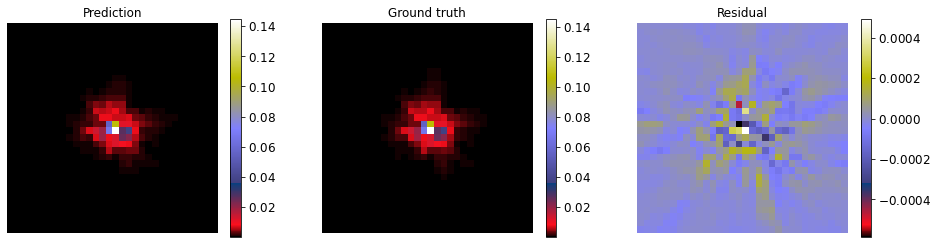

In [10]:

it = 2

fig, ax = plt.subplots(1, 3, figsize=(16,4))

im = ax[0].imshow(preds[it,:,:], cmap='gist_stern')
ax[0].set_title('Prediction')
plt.colorbar(im, ax=ax[0])


im = ax[1].imshow(GT_preds[it,:,:], cmap='gist_stern')
ax[1].set_title('Ground truth')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(GT_preds[it,:,:] - preds[it,:,:], cmap='gist_stern')
ax[2].set_title('Residual')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.show()




## Recovery @ 3x Euclid resolution

In [11]:
output_Q=1
output_dim=64


# Save original output_Q and output_dim
original_out_Q = tf_semiparam_field.output_Q
original_out_dim = tf_semiparam_field.output_dim
GT_original_out_Q = GT_tf_semiparam_field.output_Q
GT_original_out_dim = GT_tf_semiparam_field.output_dim

# Set the required output_Q and output_dim parameters in the models
tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)

# Need to compile the models again
tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)


# Generate SED data list
packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]

# Prepare inputs
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])
pred_inputs = [tf_test_pos , tf_packed_SED_data]

# PSF model
predictions = tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)

# Ground Truth model
GT_predictions = GT_tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)

    

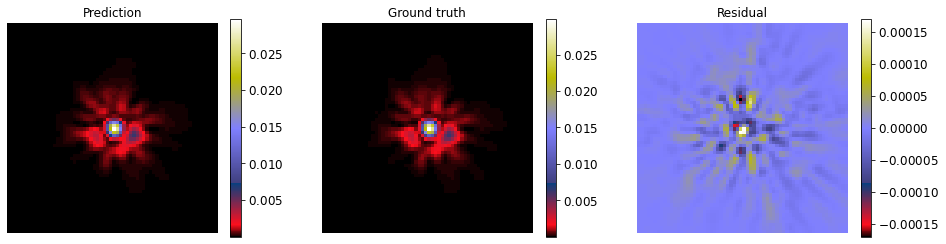

In [12]:

it = 2

fig, ax = plt.subplots(1, 3, figsize=(16,4))

im = ax[0].imshow(predictions[it,:,:], cmap='gist_stern')
ax[0].set_title('Prediction')
plt.colorbar(im, ax=ax[0])


im = ax[1].imshow(GT_predictions[it,:,:], cmap='gist_stern')
ax[1].set_title('Ground truth')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(GT_predictions[it,:,:] - predictions[it,:,:], cmap='gist_stern')
ax[2].set_title('Residual')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.show()


## Monochromatic reconstruction @ 750nm , 3x Euclid resolution

In [13]:

# Uncomment block to return to Euclid resolution
"""
# Re-et the original output_Q and output_dim parameters in the models
tf_semiparam_field.set_output_Q(output_Q=original_out_Q, output_dim=original_out_dim)
GT_tf_semiparam_field.set_output_Q(output_Q=GT_original_out_Q, output_dim=GT_original_out_dim)

# Need to compile the models again
tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)
"""

lambda_obs = 0.750

phase_N = simPSF_np.feasible_N(lambda_obs)
batch_pos = tf_test_pos

# Estimate the monochromatic PSFs
GT_mono_psf = GT_tf_semiparam_field.predict_mono_psfs(
    input_positions=batch_pos,
    lambda_obs=lambda_obs,
    phase_N=phase_N)

model_mono_psf = tf_semiparam_field.predict_mono_psfs(
    input_positions=batch_pos,
    lambda_obs=lambda_obs,
    phase_N=phase_N)



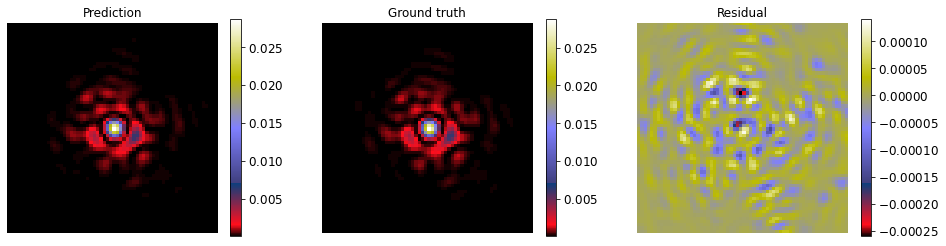

In [14]:


it = 2

fig, ax = plt.subplots(1, 3, figsize=(16,4))

im = ax[0].imshow(model_mono_psf[it,:,:], cmap='gist_stern')
ax[0].set_title('Prediction')
plt.colorbar(im, ax=ax[0])

im = ax[1].imshow(GT_mono_psf[it,:,:], cmap='gist_stern')
ax[1].set_title('Ground truth')
plt.colorbar(im, ax=ax[1])

im = ax[2].imshow(GT_mono_psf[it,:,:] - model_mono_psf[it,:,:], cmap='gist_stern')
ax[2].set_title('Residual')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.show()




## OPD reconstruction

In [15]:

batch_pos = tf_test_pos

# We calculate a batch of OPDs
opd_batch = tf_semiparam_field.predict_opd(batch_pos)
GT_opd_batch = GT_tf_semiparam_field.predict_opd(batch_pos)
        

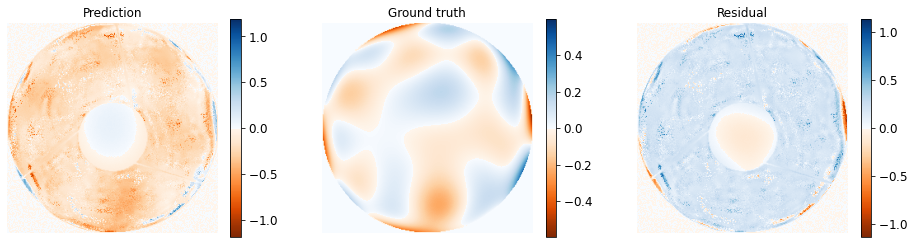

In [16]:


it = 2

fig, ax = plt.subplots(1, 3, figsize=(16,4))

vmax = np.max(abs(opd_batch[it,:,:]))
im = ax[0].imshow(opd_batch[it,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[0].set_title('Prediction')
plt.colorbar(im, ax=ax[0])


vmax = np.max(abs(GT_opd_batch[it,:,:]))
im = ax[1].imshow(GT_opd_batch[it,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[1].set_title('Ground truth')
plt.colorbar(im, ax=ax[1])

vmax = np.max(abs(GT_opd_batch[it,:,:] - opd_batch[it,:,:]))
im = ax[2].imshow(GT_opd_batch[it,:,:] - opd_batch[it,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
ax[2].set_title('Residual')
plt.colorbar(im, ax=ax[2])

for j in range(3):
    ax[j].set_xticks([])
    ax[j].set_yticks([])
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['bottom'].set_visible(False)
    ax[j].spines['left'].set_visible(False)

plt.show()





# Star reconstruction

In [17]:
# Selected star reconsruction
it = 2

# Polychromatic Reconstruction: Euclid resolution
# preds
# GT_preds
poly_pred = preds[it,:,:]
poly_GT = GT_preds[it,:,:]
poly_res = poly_GT - poly_pred

# Polychromatic Reconstruction: 3x Euclid resolution
# predictions
# GT_predictions
poly_SR_pred = predictions[it,:,:]
poly_SR_GT = GT_predictions[it,:,:]
poly_SR_res = poly_SR_GT - poly_SR_pred

# Monochromatic Reconstruction: 3x Euclid resolution
# model_mono_psf
# GT_mono_psf
mono_SR_pred = model_mono_psf[it,:,:]
mono_SR_GT = GT_mono_psf[it,:,:]
mono_SR_res = mono_SR_GT - mono_SR_pred

# OPD 
opd_pred = opd_batch[it,:,:]
opd_GT = GT_opd_batch[it,:,:]
opd_res = GT_opd_batch[it,:,:] - opd_batch[it,:,:]





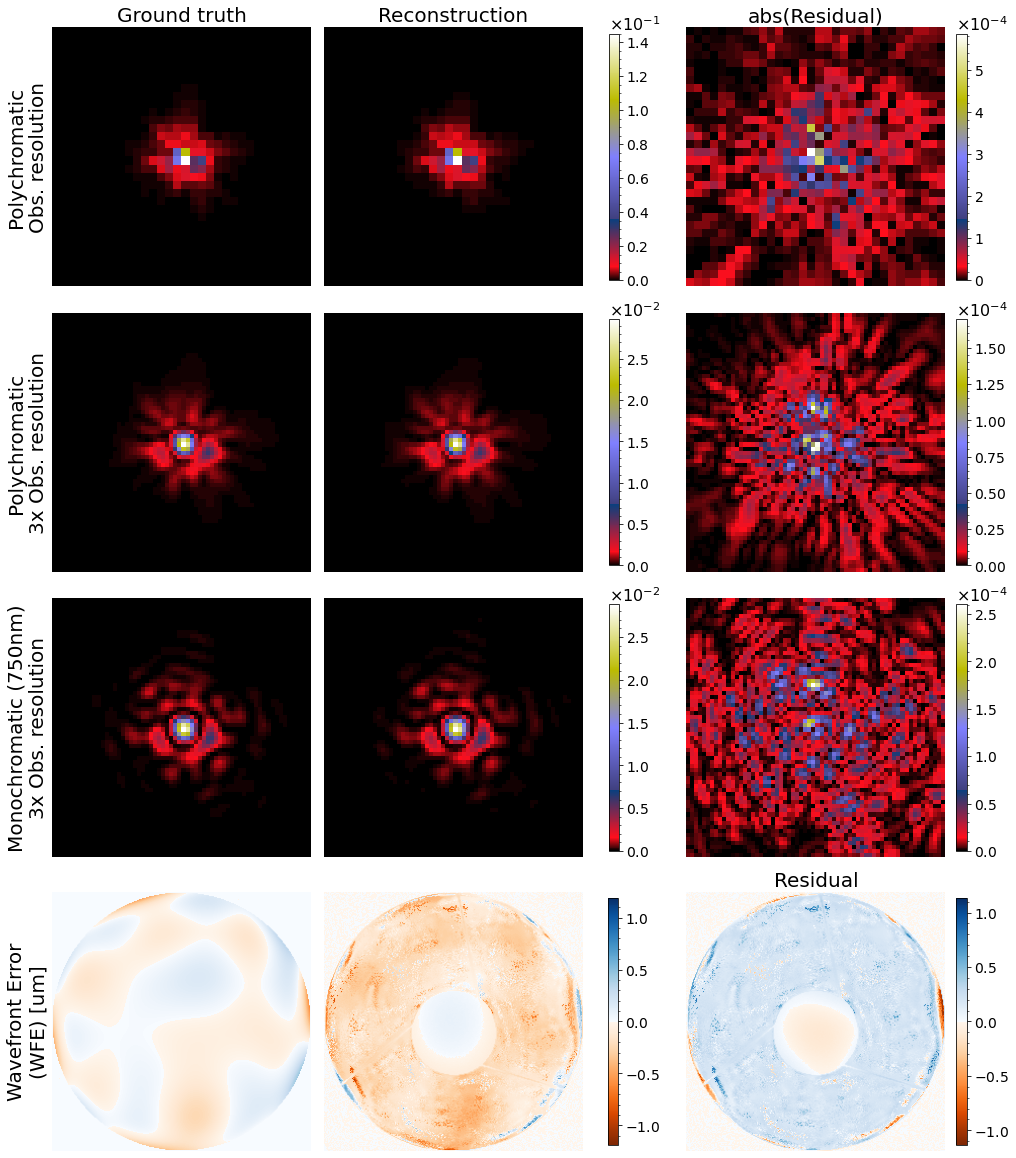

In [18]:

plot_style = {
    'axes.formatter.use_mathtext': True,
    'text.usetex': False,
}
mpl.rcParams.update(plot_style)


def_cmap = 'gist_stern'

fig, axs = plt.subplots(4, 3, figsize=(14, 16), constrained_layout=True)


shrink_nat = 0.92
shrink_res = 0.92

nat_format = '%.2e'
res_format = '%.2e'

tick_size = 14
offset_text_size = 16
title_size = 20 


# Polychromatic: Euclid resolution

# GT
poly_vmax = np.max([abs(poly_pred), abs(poly_GT)])
im = axs[0,0].imshow(poly_GT, cmap=def_cmap, vmax=poly_vmax, vmin=0)
axs[0,0].set_xticks([]);axs[0,0].set_yticks([])
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].spines['bottom'].set_visible(False)
axs[0,0].spines['left'].set_visible(False)
axs[0,0].set_title(r"Ground truth", fontdict={'fontsize':title_size})
axs[0,0].set_ylabel(r"Polychromatic" "\n" r"Obs. resolution", fontdict={'fontsize':title_size})
# Pred
im = axs[0,1].imshow(poly_pred, cmap=def_cmap, vmax=poly_vmax, vmin=0)
axs[0,1].set_xticks([]);axs[0,1].set_yticks([])
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].spines['bottom'].set_visible(False)
axs[0,1].spines['left'].set_visible(False)
axs[0,1].set_title(r"Reconstruction", fontdict={'fontsize':title_size})
cbar = fig.colorbar(im, ax=[axs[0,0], axs[0,1]], shrink=shrink_nat)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

# Residual
vmax = np.max(abs(poly_res))
im = axs[0,2].imshow(abs(poly_res), cmap=def_cmap, vmax=vmax, vmin=0)
axs[0,2].set_xticks([]);axs[0,2].set_yticks([])
axs[0,2].spines['top'].set_visible(False)
axs[0,2].spines['right'].set_visible(False)
axs[0,2].spines['bottom'].set_visible(False)
axs[0,2].spines['left'].set_visible(False)
axs[0,2].set_title(r"abs(Residual)", fontdict={'fontsize':title_size})

cbar = fig.colorbar(im, ax=axs[0,2], shrink=shrink_res)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

# Polychromatic: 3x Euclid resolution

# GT
poly_vmax = np.max([abs(poly_SR_pred), abs(poly_SR_GT)])
im = axs[1,0].imshow(poly_SR_GT, cmap=def_cmap, vmax=poly_vmax, vmin=0)
axs[1,0].set_xticks([]);axs[1,0].set_yticks([])
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].spines['bottom'].set_visible(False)
axs[1,0].spines['left'].set_visible(False)
axs[1,0].set_ylabel(r"Polychromatic" "\n" "3x Obs. resolution", fontdict={'fontsize':title_size})
# Pred
im = axs[1,1].imshow(poly_SR_pred, cmap=def_cmap, vmax=poly_vmax, vmin=0)
axs[1,1].set_xticks([]);axs[1,1].set_yticks([])
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].spines['bottom'].set_visible(False)
axs[1,1].spines['left'].set_visible(False)

cbar = fig.colorbar(im, ax=[axs[1,0], axs[1,1]], shrink=shrink_nat)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

# Residual
vmax = np.max(abs(poly_SR_res))
im = axs[1,2].imshow(abs(poly_SR_res), cmap=def_cmap, vmax=vmax, vmin=0)
axs[1,2].set_xticks([]);axs[1,2].set_yticks([])
axs[1,2].spines['top'].set_visible(False)
axs[1,2].spines['right'].set_visible(False)
axs[1,2].spines['bottom'].set_visible(False)
axs[1,2].spines['left'].set_visible(False)

cbar = fig.colorbar(im, ax=axs[1,2], shrink=shrink_res)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

# Monochromatic 

# GT
poly_vmax = np.max([abs(mono_SR_pred), abs(mono_SR_GT)])
im = axs[2,0].imshow(mono_SR_GT, cmap=def_cmap, vmax=poly_vmax, vmin=0)
axs[2,0].set_xticks([]);axs[2,0].set_yticks([])
axs[2,0].spines['top'].set_visible(False)
axs[2,0].spines['right'].set_visible(False)
axs[2,0].spines['bottom'].set_visible(False)
axs[2,0].spines['left'].set_visible(False)
axs[2,0].set_ylabel(r"Monochromatic (750nm)" "\n" "3x Obs. resolution", fontdict={'fontsize':title_size})
# Pred
im = axs[2,1].imshow(mono_SR_pred, cmap=def_cmap, vmax=poly_vmax, vmin=0)
axs[2,1].set_xticks([]);axs[2,1].set_yticks([])
axs[2,1].spines['top'].set_visible(False)
axs[2,1].spines['right'].set_visible(False)
axs[2,1].spines['bottom'].set_visible(False)
axs[2,1].spines['left'].set_visible(False)

cbar = fig.colorbar(im, ax=[axs[2,0], axs[2,1]], shrink=shrink_nat)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

# Residual
vmax = np.max(abs(mono_SR_res))
im = axs[2,2].imshow(abs(mono_SR_res), cmap=def_cmap, vmax=vmax, vmin=0)
axs[2,2].set_xticks([]);axs[2,2].set_yticks([])
axs[2,2].spines['top'].set_visible(False)
axs[2,2].spines['right'].set_visible(False)
axs[2,2].spines['bottom'].set_visible(False)
axs[2,2].spines['left'].set_visible(False)

cbar = fig.colorbar(im, ax=axs[2,2], shrink=shrink_res)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()


# OPD 

# GT
opd_max = np.max([abs(opd_pred), abs(opd_GT)])
im = axs[3,0].imshow(opd_GT, cmap=newcmp, vmax=opd_max, vmin=-opd_max)
axs[3,0].set_xticks([]);axs[3,0].set_yticks([])
axs[3,0].spines['top'].set_visible(False)
axs[3,0].spines['right'].set_visible(False)
axs[3,0].spines['bottom'].set_visible(False)
axs[3,0].spines['left'].set_visible(False)
axs[3,0].set_ylabel(r"Wavefront Error" "\n" "(WFE) [um]", fontdict={'fontsize':title_size})
# Pred
im = axs[3,1].imshow(opd_pred, cmap=newcmp, vmax=opd_max, vmin=-opd_max)
axs[3,1].set_xticks([]);axs[3,1].set_yticks([])
axs[3,1].spines['top'].set_visible(False)
axs[3,1].spines['right'].set_visible(False)
axs[3,1].spines['bottom'].set_visible(False)
axs[3,1].spines['left'].set_visible(False)

cbar = fig.colorbar(im, ax=[axs[3,0], axs[3,1]], shrink=shrink_nat)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()

# Residual
opd_res_vmax = np.max(abs(opd_res))
im = axs[3,2].imshow(opd_res, cmap=newcmp, vmax=opd_res_vmax, vmin=-opd_res_vmax)
axs[3,2].set_xticks([]);axs[3,2].set_yticks([])
axs[3,2].spines['top'].set_visible(False)
axs[3,2].spines['right'].set_visible(False)
axs[3,2].spines['bottom'].set_visible(False)
axs[3,2].spines['left'].set_visible(False)
axs[3,2].set_title(r"Residual", fontdict={'fontsize':title_size})

cbar = fig.colorbar(im, ax=axs[3,2], shrink=shrink_res)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()


plt.savefig(saving_dir + 'PSF_reconstruction_example.pdf')


plt.show()


# Star observations and wavefront

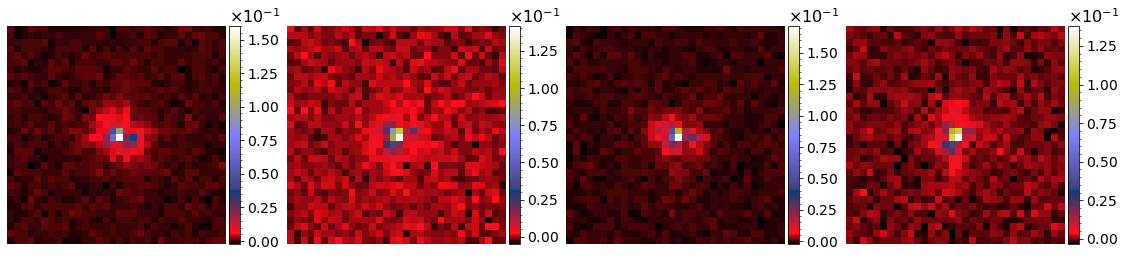

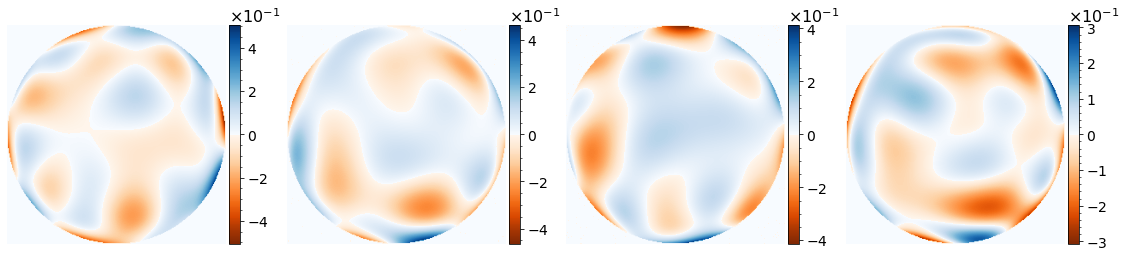

In [19]:

# Selected stars
id_maps = [1, 10, 19, 40]


# Pixel observation
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

for it in range(len(id_maps)):
    vmax = np.max(noisy_train_stars[id_maps[it],:,:])
    im = axs[it].imshow(noisy_train_stars[id_maps[it],:,:], cmap='gist_stern')
    divider = make_axes_locatable(axs[it])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)#, extend='both')
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=tick_size)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.offsetText.set(size=offset_text_size)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    axs[it].set_xticks([])
    axs[it].set_yticks([])
    axs[it].spines['top'].set_visible(False)
    axs[it].spines['right'].set_visible(False)
    axs[it].spines['bottom'].set_visible(False)
    axs[it].spines['left'].set_visible(False)

plt.savefig(saving_dir + 'observed_stars.pdf')

plt.show()



# Wavefront representations
batch_pos = tf_train_pos.numpy()[id_maps,:]
GT_train_opd_batch = GT_tf_semiparam_field.predict_opd(batch_pos)

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

for it in range(len(id_maps)):
    vmax = np.max(abs(GT_train_opd_batch[it,:,:]))
    im = axs[it].imshow(GT_train_opd_batch[it,:,:], cmap=newcmp, vmax=vmax, vmin=-vmax)
    divider = make_axes_locatable(axs[it])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)#, extend='both')
    cbar.minorticks_on()
    cbar.ax.tick_params(labelsize=tick_size)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.offsetText.set(size=offset_text_size)
    cbar.ax.yaxis.set_offset_position('left')
    cbar.update_ticks()
    axs[it].set_xticks([])
    axs[it].set_yticks([])
    axs[it].spines['top'].set_visible(False)
    axs[it].spines['right'].set_visible(False)
    axs[it].spines['bottom'].set_visible(False)
    axs[it].spines['left'].set_visible(False)

plt.savefig(saving_dir + 'observed_OPD.pdf')

plt.show()




# Example PSF figure

### Chromatic reconstruction

In [44]:

lambda_list = [0.551, 0.6, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9]
phase_N_list = [simPSF_np.feasible_N(_lam) for _lam in lambda_list]

single_position = batch_pos[0:2,:]
# single_position = tf_train_pos[0:3,:]

tf_SEDs = train_SEDs[0:20,:,:]


In [45]:
output_Q = 1
output_dim = 64


# Save original output_Q and output_dim
original_out_Q = tf_semiparam_field.output_Q
original_out_dim = tf_semiparam_field.output_dim
GT_original_out_Q = GT_tf_semiparam_field.output_Q
GT_original_out_dim = GT_tf_semiparam_field.output_dim

# Set the required output_Q and output_dim parameters in the models
tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)

# Need to compile the models again
tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)





ex_mono_psf = []

for single_lambda, single_phase_N in zip(lambda_list, phase_N_list):
    
    mono_psf = GT_tf_semiparam_field.predict_mono_psfs(
        input_positions=single_position,
        lambda_obs=single_lambda,
        phase_N=single_phase_N
    )
    
    ex_mono_psf.append(mono_psf.numpy()[0,:,:])


<ipython-input-46-76bdf827b8b8>:2: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)


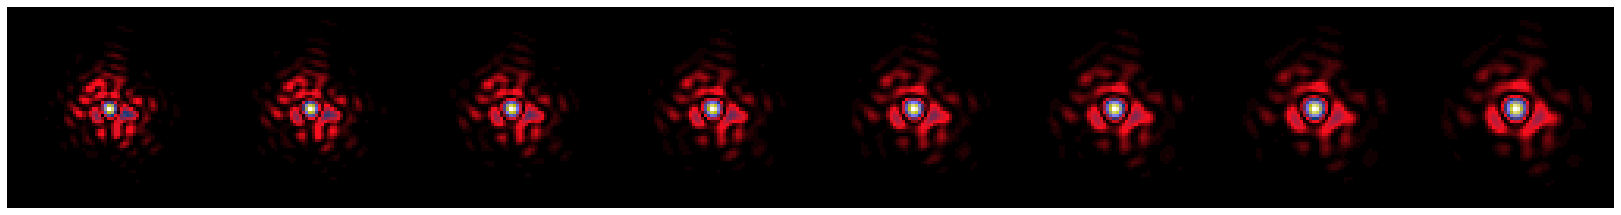

In [46]:

fig, axs = plt.subplots(1, len(lambda_list), figsize=(24, 4), constrained_layout=True)
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

for it in range(len(lambda_list)):

    im = axs[it].imshow(ex_mono_psf[it], cmap='gist_stern')#, vmax=vmax, vmin=-vmax)
    axs[it].set_xticks([])
    axs[it].set_yticks([])
    axs[it].spines['top'].set_visible(False)
    axs[it].spines['right'].set_visible(False)
    axs[it].spines['bottom'].set_visible(False)
    axs[it].spines['left'].set_visible(False)
    axs[it].set_aspect('equal')

plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
plt.savefig(saving_dir + 'chromatic_PSFs.pdf')
plt.show()



### Polychromatic obs @ Eculid resolution

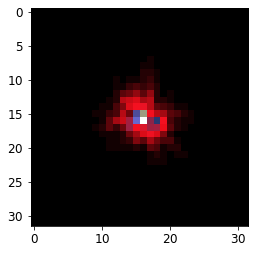

In [47]:

output_Q=3
output_dim=32


# Save original output_Q and output_dim
original_out_Q = tf_semiparam_field.output_Q
original_out_dim = tf_semiparam_field.output_dim
GT_original_out_Q = GT_tf_semiparam_field.output_Q
GT_original_out_dim = GT_tf_semiparam_field.output_dim

# Set the required output_Q and output_dim parameters in the models
tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)

# Need to compile the models again
tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)


# Generate SED data list
packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]

# Prepare inputs
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])
pred_inputs = [batch_pos[0:2,:] , tf_packed_SED_data[0:2,:,:]]

# PSF model
predictions = tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)

# Ground Truth model
GT_predictions = GT_tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)


poly_PSF = GT_predictions[0,:,:]

figure()
imshow(poly_PSF, cmap='gist_stern')
show()




### Polychromatic obs @ 3x Eculid resolution

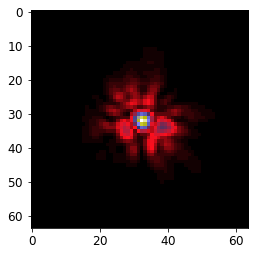

In [48]:
output_Q=1
output_dim=64


# Save original output_Q and output_dim
original_out_Q = tf_semiparam_field.output_Q
original_out_dim = tf_semiparam_field.output_dim
GT_original_out_Q = GT_tf_semiparam_field.output_Q
GT_original_out_dim = GT_tf_semiparam_field.output_dim

# Set the required output_Q and output_dim parameters in the models
tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)
GT_tf_semiparam_field.set_output_Q(output_Q=output_Q, output_dim=output_dim)

# Need to compile the models again
tf_semiparam_field = wf.tf_psf_field.build_PSF_model(tf_semiparam_field)
GT_tf_semiparam_field = wf.tf_psf_field.build_PSF_model(GT_tf_semiparam_field)


# Generate SED data list
packed_SED_data = [wf.utils.generate_packed_elems(_sed, simPSF_np, n_bins=n_bins_lda)
                        for _sed in tf_SEDs]

# Prepare inputs
tf_packed_SED_data = tf.convert_to_tensor(packed_SED_data, dtype=tf.float32)
tf_packed_SED_data = tf.transpose(tf_packed_SED_data, perm=[0, 2, 1])
pred_inputs = [batch_pos[0:2,:] , tf_packed_SED_data[0:2,:,:]]

# PSF model
predictions = tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)

# Ground Truth model
GT_predictions = GT_tf_semiparam_field.predict(x=pred_inputs, batch_size=batch_size)


SR_poly_PSF = GT_predictions[0,:,:]

figure()
imshow(SR_poly_PSF, cmap='gist_stern')
show()



### OPD reconstruction


In [49]:

GT_opd_batch = GT_tf_semiparam_field.predict_opd(batch_pos[0:2,:])

opd_psf = GT_opd_batch.numpy()[0,:,:]


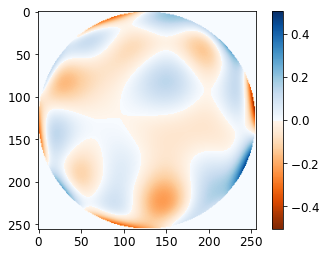

In [50]:

vmax = np.max(abs(opd_psf))
figure()
imshow(opd_psf, cmap=newcmp, vmax=vmax, vmin=-vmax);colorbar()
show()


### Noisy observation

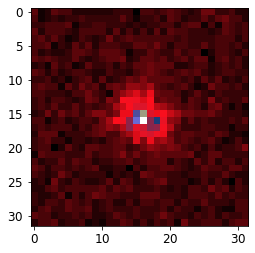

In [52]:

# noisy_obs = tf_noisy_train_stars[1,:,:]
noisy_obs = tf_noisy_train_stars.numpy()[id_maps,:]
noisy_obs = noisy_obs[0,:,:]

figure()
imshow(noisy_obs, cmap='gist_stern')
show()



### Plot together

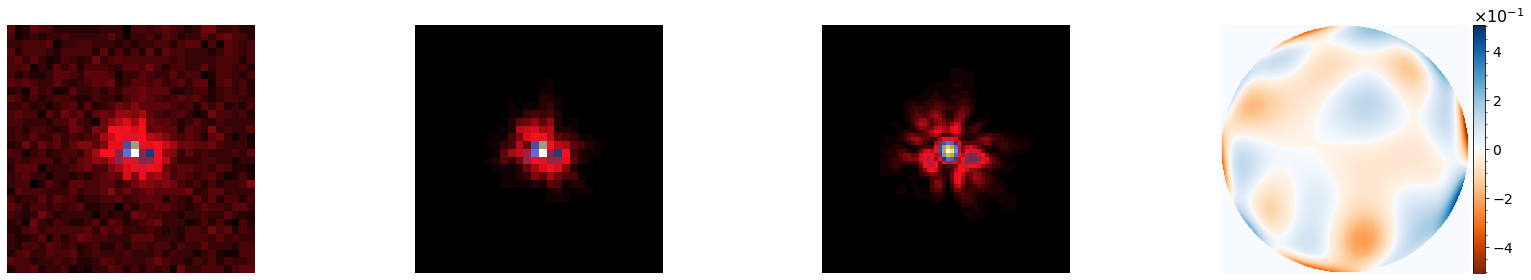

In [53]:

# noisy_obs
# opd_psf
# SR_poly_PSF
# poly_PSF
# ex_mono_psf



fig, axs = plt.subplots(1, 4, figsize=(24, 4))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)



im = axs[0].imshow(noisy_obs, cmap='gist_stern')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)

im = axs[1].imshow(poly_PSF, cmap='gist_stern')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)

im = axs[2].imshow(SR_poly_PSF, cmap='gist_stern')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].spines['left'].set_visible(False)

vmax = np.max(abs(opd_psf))
im = axs[3].imshow(opd_psf, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs[3])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].spines['bottom'].set_visible(False)
axs[3].spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(saving_dir + 'PSF_example_together.pdf')

plt.show()


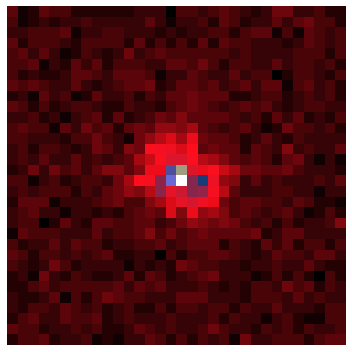

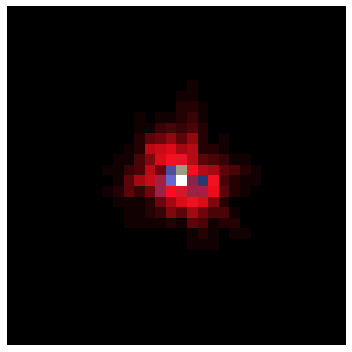

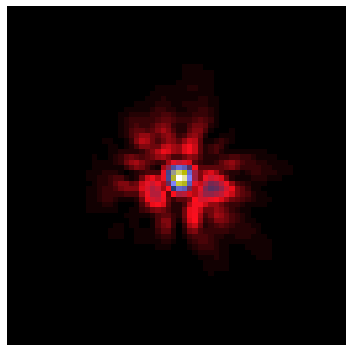

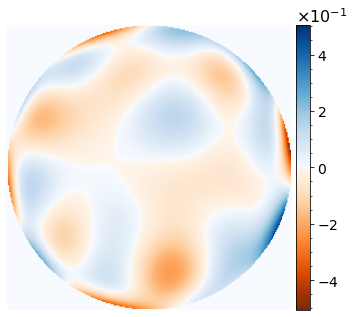

In [54]:

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

im = axs.imshow(noisy_obs, cmap='gist_stern')
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(saving_dir + 'observation_example.pdf')
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

im = axs.imshow(poly_PSF, cmap='gist_stern')
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(saving_dir + 'polyPSF_example.pdf')
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

im = axs.imshow(SR_poly_PSF, cmap='gist_stern')
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(saving_dir + 'polyPSF_SR_example.pdf')
plt.show()


fig, axs = plt.subplots(1, 1, figsize=(5, 5))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.2)

vmax = np.max(abs(opd_psf))
im = axs.imshow(opd_psf, cmap=newcmp, vmax=vmax, vmin=-vmax)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax)#, extend='both')
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=tick_size)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.offsetText.set(size=offset_text_size)
cbar.ax.yaxis.set_offset_position('left')
cbar.update_ticks()
axs.set_xticks([])
axs.set_yticks([])
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig(saving_dir + 'opd_example.pdf')
plt.show()
